# Quantum bath coupled to a localized chain - an introduction

## Contents of this notebook

This notebook is intended as a test of the implementation of the
random ergodic grain included in the larger Hamiltonian. The theory
is given in the paper by David Luitz et. al. on ["How a small
quantum bath can thermalize a long localized chain."](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.150602)

### Some preliminary calculations, instantiation of the Hamiltonian etc.

In [1]:
# import what needs to be imported
%matplotlib inline
"""
Each of the modules defined in ham1d.models defines a class
for construction of a particular hamiltonian type. All of the
classes share the same base class and thus their functionality
is more or less the same, the difference is in the internal routines
used.
"""

import numpy as np
import matplotlib.pyplot as plt
# to load classes utilizing numba's jit
# compilation optimizations, load the following
# modules. The following lines would load modules
# with routines for creation of spin 1/2 (hard-core
# bosonic), spinless fermionic and noninteracting
# hamiltonians.
# in case of the spin 1/2 hamiltonians,
# one can also construct the model hamiltonians
# using the kronecker product of sparse operators.
# In general, this could be easily achieved for
# any spin value, simply by providing an appropriate
# set of spin operators. For now, only the spin 1/2
# matrices are provided.
from ham1d.models import spin1d as sp1
from ham1d.models import spin1d_kron as spk


### Define the model constants

For now, we resort to those used in the paper.
With $L_\mathrm{b}$, we denote the bath length, while $L_\mathrm{loc}$
denotes the length of the localized portion of the system. Disorder
strength parameter is denoted, as usually, by $W$ and $g_0$ and $\alpha$ specify
the couplings of LIOMs to the bath, respectively. Bath parameters are controlled by
setting the value of $\beta$.
We also provide a brief explanation in the comments.


In [2]:
# bath length
L_b = 3
# length of the localized part
L_loc = 5

g0 = 1.
beta = 0.3

# the subcritical alpha - specifies
# localized behavior - e.g., an ergodic
# grain should not be able to delocalize
# LIOMs of a sufficiently large system
alpha = 0.9
# the disorder parameter
W = 0.5

### Set up the Hamiltonian

In [3]:

def give_the_static_list(L_b, L_loc, g0,
                         beta, alpha, W, seed=0):
    """
    Returns the list of terms
    which specify the intersite
    couplings and onsite potentials
    for our Hamiltonian.
    
    """
    rng = np.random.default_rng(seed)
    # We first need to define
    # the site coupling list:
    # the first entry in the nested list is always the value of the exchange constant
    # the following entries are integers specifying the sites on which the operators act.
    bath_couplings = [[g0*alpha**j, L_b+j, L_b-1] for j,i in enumerate(range(L_b, L_b + L_loc))]
    # then, specify the operators:
    bath_loc_term = ['xx', bath_couplings] 

    # the first entry is the operator specification string (opstring), the second one is the site coupling
    # list. len(list(opstring)) should match the number of sites in the site coupling list, otherwise the
    # could will raise an error.
    # The allowed operators in the spin case
    # are:
    # {'+': s+, '-': s-, 'I': id2, 'x': sx, 'y': sy, 'z': sz, 'RR': None}

    # the specification of operators together with the site-coupling list bath_couplings completely
    # determines one single hamiltonian term. 

    # Let's now define the other hamiltonian terms

    #random field
    fields = rng.uniform(1 - W, 1 + W, L_loc)
    W_z = [[fields[j], i] for j, i in enumerate(range(L_b, L_b + L_loc))]
    rnd_term = ['z', W_z]
    # random grain: Note that a special implementation was needed for
    # this
    grain_term = ['RR', [[0.5, 0, L_b-1]]]

    # we can now put together the static_list -> just a list of hamiltonian term
    # definitions

    static_list = [bath_loc_term, rnd_term, grain_term]
    
    return static_list

In [6]:
# generate the hamiltonian
params = [L_b, L_loc, g0, beta, alpha, W, 0]
static_list = give_the_static_list(*params)
ham_sp1 = sp1.hamiltonian(params[0]+params[1], static_list, [], Nu=None, grain_list = [np.ones((2**(L_b-1), 2**(L_b-1)))])

ValueError: There was a shape mismatch when setting the grain list. See how the shapes matched: [False]

### Display the matrix properties, perform diagonalization etc.

Only a portion of the matrix of size $2^L \times 2^L$ is shown.

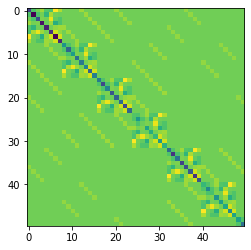

In [5]:
plt.imshow(np.real(ham_sp1.mat.todense()[:50, :50]))

In [6]:
eigvals, eigvecs = ham_sp1.eigsystem(complex=False)

### $S^z$ operator on different sites

In [7]:
szvals = np.zeros((ham_sp1.nstates, ham_sp1.L))

In [8]:
def eval_siz_sites(ham, eigstates):
    szvals = np.zeros((ham.nstates, ham.L))
    for site in range(ham.L):
        szvals[:, site] = ham.eval_diag_Siz(
            np.complex128(eigstates), site)
    return szvals

szvals = eval_siz_sites(ham_sp1, eigvecs)
#for site in range(ham_sp1.L):
#    szvals[:, site] = ham_sp1.eval_diag_Siz(np.complex128(eigvecs), site)

/home/jan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


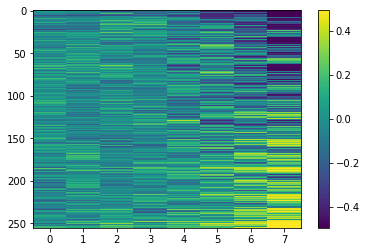

In [9]:
fig, ax1 = plt.subplots(1, 1)
pos = ax1.imshow(np.real(szvals), aspect='auto')
fig.colorbar(pos)
plt.show()

Text(0.5, 1.0, 'std. for diagonal $S^z$ operators')

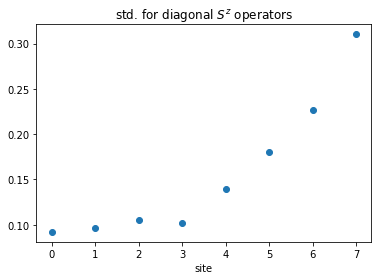

In [10]:
plt.plot(np.std(szvals, axis=0), 'o')
plt.xlabel('site')
plt.title('std. for diagonal $S^z$ operators')

## Below the critical point

In [26]:
%%capture
# q quick finite - size scaling analysis
from spectral_stats.spectra import Spectra
from spectral_stats.utils.helper_functions import running_mean

seedrange=5
lrange = 5
alpha_below = 0.1
params = [L_b, L_loc, g0, beta, alpha_below, W, 0]

# rstats & distributions
rlist = np.zeros(lrange)
distlist = []
# site standard deviations
stdzvals = []
zdistvals = []

sfflist = []
for i, L_loc in enumerate(range(5, 5+lrange)):
    
    
    en_spectra = np.zeros((seedrange, 2**(L_b+L_loc)))
    szvals_ =  []
    for seed in range(seedrange):
        params[1] = L_loc
        params[-1] = seed
        static_list = give_the_static_list(*params)
        ham_sp1 = sp1.hamiltonian(params[0]+params[1], static_list, [], Nu=None)
        eigvals, eigvecs = ham_sp1.eigsystem(complex=True)
        en_spectra[seed, :] = eigvals
        #nstates = ham_sp1.nstates
        szvals_.append(eval_siz_sites(ham_sp1, eigvecs))
    

    szvals_ = np.concatenate(szvals_)
    if i == lrange - 1:
        zdistvals.append(szvals_)
    stdzvals.append(np.std(szvals_, axis=0))
    # analyse r
    spc = Spectra(en_spectra)
    spc.spectral_width = (0., 1)
    gap_mean, gap_dev, gap_mean_dist = spc.gap_avg(
                                    return_distribution=True)
    gap_dist = spc.gap_dist()
    distlist.append(gap_dist)
    rlist[i] = gap_mean
    
    #sff
    spc.spectral_unfolding(3, merge=False, correct_slope=True)
    spc.get_ham_misc(individual=True)
    spc.spectral_filtering(filter_key='gaussian', eta=0.3)
    taulist = np.logspace(np.log10(2**(-(L_b+L_loc))), np.log10(2*5*np.pi), 100)
    spc.calc_sff(taulist, return_sfflist=False)
    sffvals = np.array([spc.taulist/(2*np.pi), spc.sff/spc.filt_dict['dims_eff']])
    sfflist.append(sffvals)


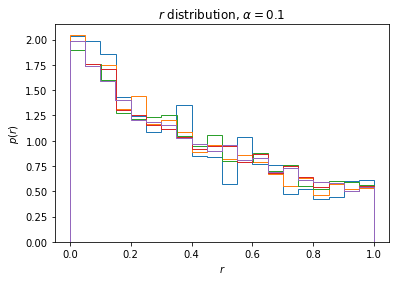

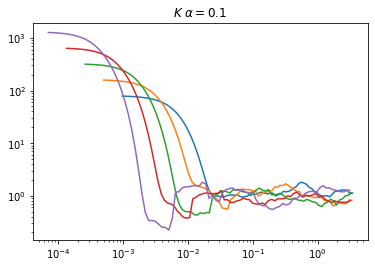

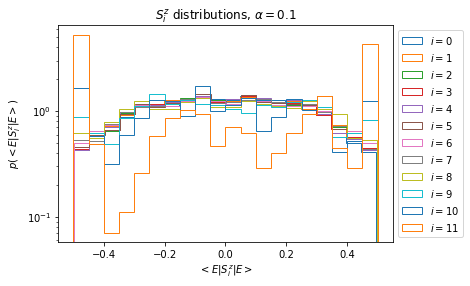

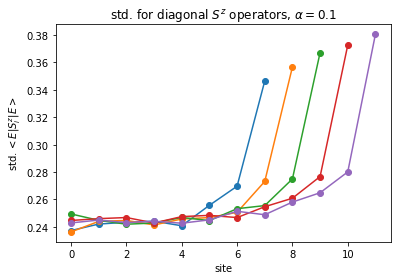

In [31]:
fig = plt.figure()
#plt.title('$r$ distribution, $\alpha$')
plt.title('$r$ distribution, $\\alpha={}$'.format(alpha_below))
for dist_ in distlist:
    
    plt.hist(dist_,20, histtype='step', density=True)

plt.xlabel('$r$')
plt.ylabel('$p(r)$')
plt.show()

fig = plt.figure()
#plt.title('$r$ distribution, $\alpha$')
plt.title('$K$ $\\alpha={}$'.format(alpha_below))
for sffval in sfflist:
    
    taulist = running_mean(sffval[0], 10)
    sff = running_mean(sffval[1], 10)
    plt.loglog(taulist, sff)
#plt.loglog(sffvals[0], sffvals[1])
#plt.xlabel('$r$')
#plt.ylabel('$p(r)$')
plt.show()


fig = plt.figure()
#plt.title('$r$ distribution, $\alpha$')
plt.title('$S_i^z$ distributions, $\\alpha={}$'.format(alpha_below))
for i, zdistval in enumerate(zdistvals[0].T):
    #print(i)
    plt.hist(zdistval ,20, histtype='step', density=True,
            label=f'$i={i}$')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.xlabel('$<E|S_i^z|E>$')
plt.ylabel('$p(<E|S_i^z|E>)$')
plt.show()



fig = plt.figure()
plt.title('std. for diagonal $S^z$ operators, $\\alpha={}$'.format(alpha_below))
for stdvals_ in stdzvals:
    
    plt.plot(stdvals_, 'o-')
plt.xlabel('site')
plt.ylabel('$\\mathrm{std.}<E|S_i^z|E>$')
#plt.xlim(4, 9)
plt.show()

### Above the critical point

In [13]:
%%capture
# q quick finite - size scaling analysis
from spectral_stats.spectra import Spectra
from spectral_stats.utils.helper_functions import running_mean

seedrange=5
lrange = 4
alpha_above = 0.9
params = [L_b, L_loc, g0, beta, alpha_above, W, 0]

# rstats & distributions
rlist = np.zeros(lrange)
distlist = []
# site standard deviations
stdzvals = []
zdistvals = []

sfflist = []
for i, L_loc in enumerate(range(5, 5+lrange)):
    
    
    en_spectra = np.zeros((seedrange, 2**(L_b+L_loc)))
    szvals_ =  []
    for seed in range(seedrange):
        params[1] = L_loc
        params[-1] = seed
        static_list = give_the_static_list(*params)
        ham_sp1 = sp1.hamiltonian(params[0]+params[1], static_list, [], Nu=None)
        eigvals, eigvecs = ham_sp1.eigsystem(complex=True)
        en_spectra[seed, :] = eigvals
        szvals_.append(eval_siz_sites(ham_sp1, eigvecs))
    

    szvals_ = np.concatenate(szvals_)
    if i == lrange - 1:
        zdistvals.append(szvals_)
    stdzvals.append(np.std(szvals_, axis=0))
    # analyse r
    spc = Spectra(en_spectra)
    spc.spectral_width = (0., 1)
    gap_mean, gap_dev, gap_mean_dist = spc.gap_avg(
                                    return_distribution=True)
    gap_dist = spc.gap_dist()
    distlist.append(gap_dist)
    rlist[i] = gap_mean
    
    #sff
    spc.spectral_unfolding(3, merge=False, correct_slope=True)
    spc.get_ham_misc(individual=True)
    spc.spectral_filtering(filter_key='gaussian', eta=0.3)
    taulist = np.logspace(np.log10(2**(-(L_b+L_loc))), np.log10(2*5*np.pi), 100)
    spc.calc_sff(taulist, return_sfflist=False)
    sffvals = np.array([spc.taulist/(2*np.pi), spc.sff/spc.filt_dict['dims_eff']])
    sfflist.append(sffvals)


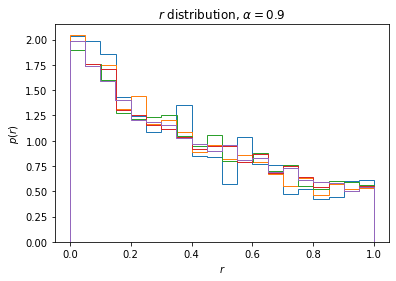

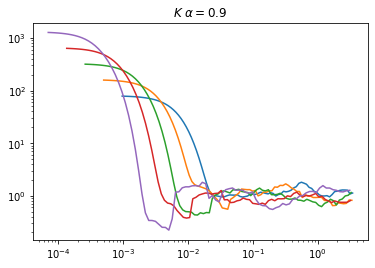

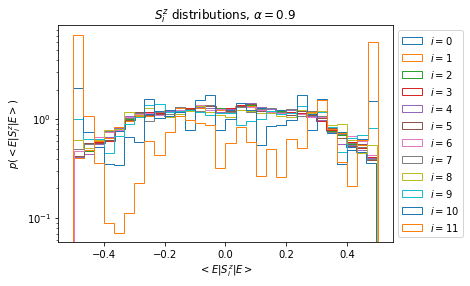

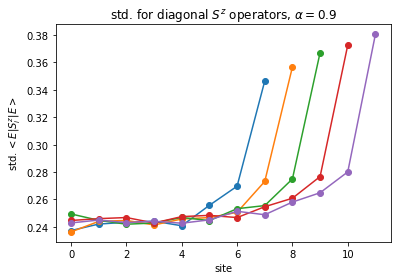

In [27]:
fig = plt.figure()
#plt.title('$r$ distribution, $\alpha$')
plt.title('$r$ distribution, $\\alpha={}$'.format(alpha_above))
for dist_ in distlist:
    
    plt.hist(dist_,20, histtype='step', density=True)

plt.xlabel('$r$')
plt.ylabel('$p(r)$')
plt.show()

fig = plt.figure()
#plt.title('$r$ distribution, $\alpha$')
plt.title('$K$ $\\alpha={}$'.format(alpha_above))
for sffval in sfflist:
    
    taulist = running_mean(sffval[0], 10)
    sff = running_mean(sffval[1], 10)
    plt.loglog(taulist, sff)
#plt.loglog(sffvals[0], sffvals[1])
#plt.xlabel('$r$')
#plt.ylabel('$p(r)$')
plt.show()

fig = plt.figure()
#plt.title('$r$ distribution, $\alpha$')
plt.title('$S_i^z$ distributions, $\\alpha={}$'.format(alpha_above))
for i, zdistval in enumerate(zdistvals[0].T):
    #print(i)
    plt.hist(zdistval ,30, histtype='step', density=True,
            label=f'$i={i}$')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.xlabel('$<E|S_i^z|E>$')
plt.ylabel('$p(<E|S_i^z|E>)$')
plt.show()


fig = plt.figure()
plt.title('std. for diagonal $S^z$ operators, $\\alpha={}$'.format(alpha_above))
for stdvals_ in stdzvals:
    
    plt.plot(np.arange(len(stdvals_)), stdvals_, 'o-')
plt.xlabel('site')
plt.ylabel('$\\mathrm{std.}<E|S_i^z|E>$')
plt.show()

### At the critical point

In [138]:
%%capture
# q quick finite - size scaling analysis
from spectral_stats.spectra import Spectra
from spectral_stats.utils.helper_functions import running_mean

seedrange=5
lrange = 4
alpha_crit = 1./np.sqrt(2)
params = [L_b, L_loc, g0, beta, alpha_crit, W, 0]

# rstats & distributions
rlist = np.zeros(lrange)
distlist = []
# site standard deviations
stdzvals = []
zdistvals = []

sfflist = []
for i, L_loc in enumerate(range(5, 5+lrange)):
    
    
    en_spectra = np.zeros((seedrange, 2**(L_b+L_loc)))
    szvals_ =  []
    for seed in range(seedrange):
        params[1] = L_loc
        params[-1] = seed
        static_list = give_the_static_list(*params)
        ham_sp1 = sp1.hamiltonian(params[0]+params[1], static_list, [], Nu=None)
        eigvals, eigvecs = ham_sp1.eigsystem(complex=True)
        en_spectra[seed, :] = eigvals
        szvals_.append(eval_siz_sites(ham_sp1, eigvecs))
    

    szvals_ = np.concatenate(szvals_)
    if i == lrange - 1:
        zdistvals.append(szvals_)
    stdzvals.append(np.std(szvals_, axis=0))
    # analyse r
    spc = Spectra(en_spectra)
    spc.spectral_width = (0., 1)
    gap_mean, gap_dev, gap_mean_dist = spc.gap_avg(
                                    return_distribution=True)
    gap_dist = spc.gap_dist()
    distlist.append(gap_dist)
    rlist[i] = gap_mean
    
    #sff
    spc.spectral_unfolding(3, merge=False, correct_slope=True)
    spc.get_ham_misc(individual=True)
    spc.spectral_filtering(filter_key='gaussian', eta=0.3)
    taulist = np.logspace(np.log10(2**(-(L_b+L_loc))), np.log10(2*5*np.pi), 100)
    spc.calc_sff(taulist, return_sfflist=False)
    sffvals = np.array([spc.taulist/(2*np.pi), spc.sff/spc.filt_dict['dims_eff']])
    sfflist.append(sffvals)


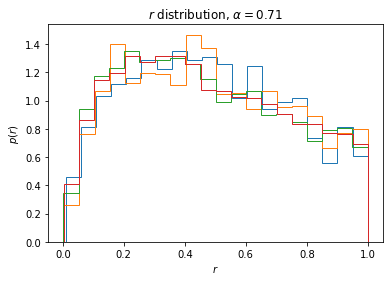

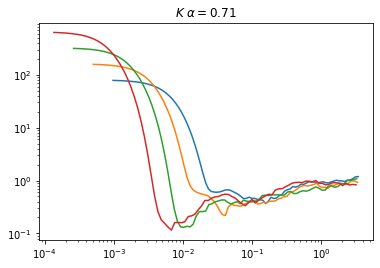

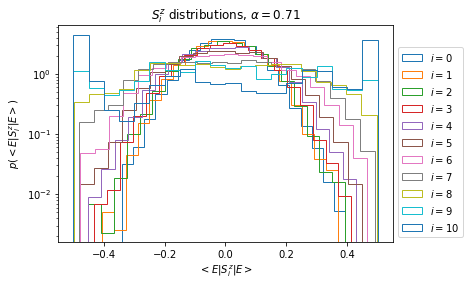

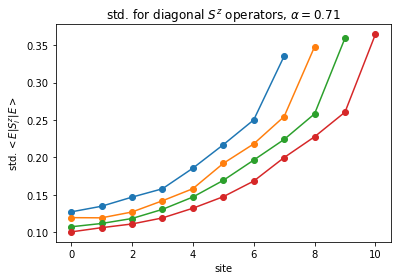

In [140]:
fig = plt.figure()
#plt.title('$r$ distribution, $\alpha$')
plt.title('$r$ distribution, $\\alpha={:.2f}$'.format(alpha_crit))
for dist_ in distlist:
    
    plt.hist(dist_,20, histtype='step', density=True)

plt.xlabel('$r$')
plt.ylabel('$p(r)$')
plt.show()

fig = plt.figure()
#plt.title('$r$ distribution, $\alpha$')
plt.title('$K$ $\\alpha={:.2f}$'.format(alpha_crit))
for sffval in sfflist:
    
    taulist = running_mean(sffval[0], 10)
    sff = running_mean(sffval[1], 10)
    plt.loglog(taulist, sff)
#plt.loglog(sffvals[0], sffvals[1])
#plt.xlabel('$r$')
#plt.ylabel('$p(r)$')
plt.show()


fig = plt.figure()
#plt.title('$r$ distribution, $\alpha$')
plt.title('$S_i^z$ distributions, $\\alpha={:.2f}$'.format(alpha_crit))
for i, zdistval in enumerate(zdistvals[0].T):
    #print(i)
    plt.hist(zdistval ,20, histtype='step', density=True,
            label=f'$i={i}$')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.xlabel('$<E|S_i^z|E>$')
plt.ylabel('$p(<E|S_i^z|E>)$')
plt.show()


fig = plt.figure()
plt.title('std. for diagonal $S^z$ operators, $\\alpha={:.2f}$'.format(alpha_crit))
for stdvals_ in stdzvals:
    
    plt.plot(stdvals_, 'o-')
plt.xlabel('site')
plt.ylabel('$\\mathrm{std.}<E|S_i^z|E>$')
plt.show()

In [129]:
taulist

array([271.56396531, 260.34371046, 249.58704481, 239.27481415,
       229.38865569, 219.91096534, 210.82486634, 202.11417924,
       193.7633931 , 185.75763781, 178.08265769, 170.72478604,
       163.67092083, 156.90850137, 150.42548596, 144.2103304 ,
       138.25196749, 132.53978729, 127.0636182 , 121.81370894,
       116.78071107, 111.95566244, 107.32997117, 102.89540038,
        98.64405351,  94.56836026,  90.66106313,  86.91520446,
        83.32411408,  79.8813974 ,  76.58092402,  73.41681688,
        70.38344168,  67.47539698,  64.68750445,  62.01479975,
        59.45252365,  56.99611356,  54.64119538,  52.38357575,
        50.21923459,  48.14431787,  46.15513085,  44.24813141,
        42.41992379,  40.66725253,  38.9869967 ,  37.37616428,
        35.8318869 ,  34.3514147 ,  32.93211142,  31.57144973,
        30.26700674,  29.01645964,  27.81758161,  26.66823783,
        25.56638168,  24.51005111,  23.49736513,  22.52652048,
        21.59578837,  20.70351149,  19.84810096,  19.02

In [ ]:
taulist